#Proyecto 4
###Redes Neuronales Convolucionales
####Daniel Rodriguez - 201715684


En primer lugar, se importan las librerias y funciones necesarias para desarrollar el proyecto.

In [1]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import os
import cv2
import keras
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,ConfusionMatrixDisplay



In [2]:
! ls

sample_data


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
ruta='drive/MyDrive/proyecto_final/PV01'
os.chdir(ruta)

Mounted at /content/drive


Se carga el set de datos y se transforma a un formato adecuado.

In [13]:

y=[]
x=[]
l_carpetas = os.listdir()
for i in l_carpetas:
  l_imagenes=os.listdir(i)
  for j in l_imagenes:   
    if 'label' not in j:
      img = imageio.imread(i+'/'+j)
      label=imageio.imread(i+'/'+j[:-4]+'_label.bmp')
      x.append(cv2.resize(img,(224,224))/255)
      y.append(np.round(cv2.resize(label,(224,224))/255))

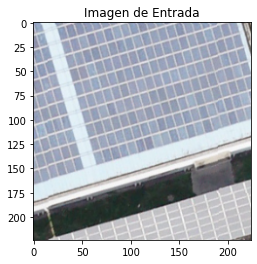

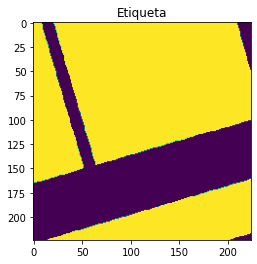

In [63]:
plt.imshow(x[0])
plt.title('Imagen de Entrada')
plt.show()
plt.imshow(y[0])
plt.title('Etiqueta')
plt.show()

Se realiza el split para el set de entrenamiento, el set de prueba y el set de validación.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.3,random_state=3)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5,random_state=3)

In [65]:
print('El set de entrenamiento tiene dimensiones:',np.shape(x_train))
print('El set de validacion tiene dimensiones:',np.shape(x_valid))
print('El set de prueba tiene dimensiones:',np.shape(x_test))

El set de entrenamiento tiene dimensiones: (451, 224, 224, 3)
El set de validacion tiene dimensiones: (97, 224, 224, 3)
El set de prueba tiene dimensiones: (97, 224, 224, 3)


Se carga el modelo pre entrenado

In [6]:
% pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-8_uee7ip
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-8_uee7ip
  Created wheel for tensorflow-examples: filename=tensorflow_examples-c62c9ec403b441913c987cacdfaf4d7a0bf0e7f2_-py3-none-any.whl size=299285 sha256=418f5be24a60b643634fa4b6b5b9e951b6d11142c3bbff1ad363135bd155eb33
  Stored in directory: /tmp/pip-ephem-wheel-cache-ire09rb9/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [20]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt



base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



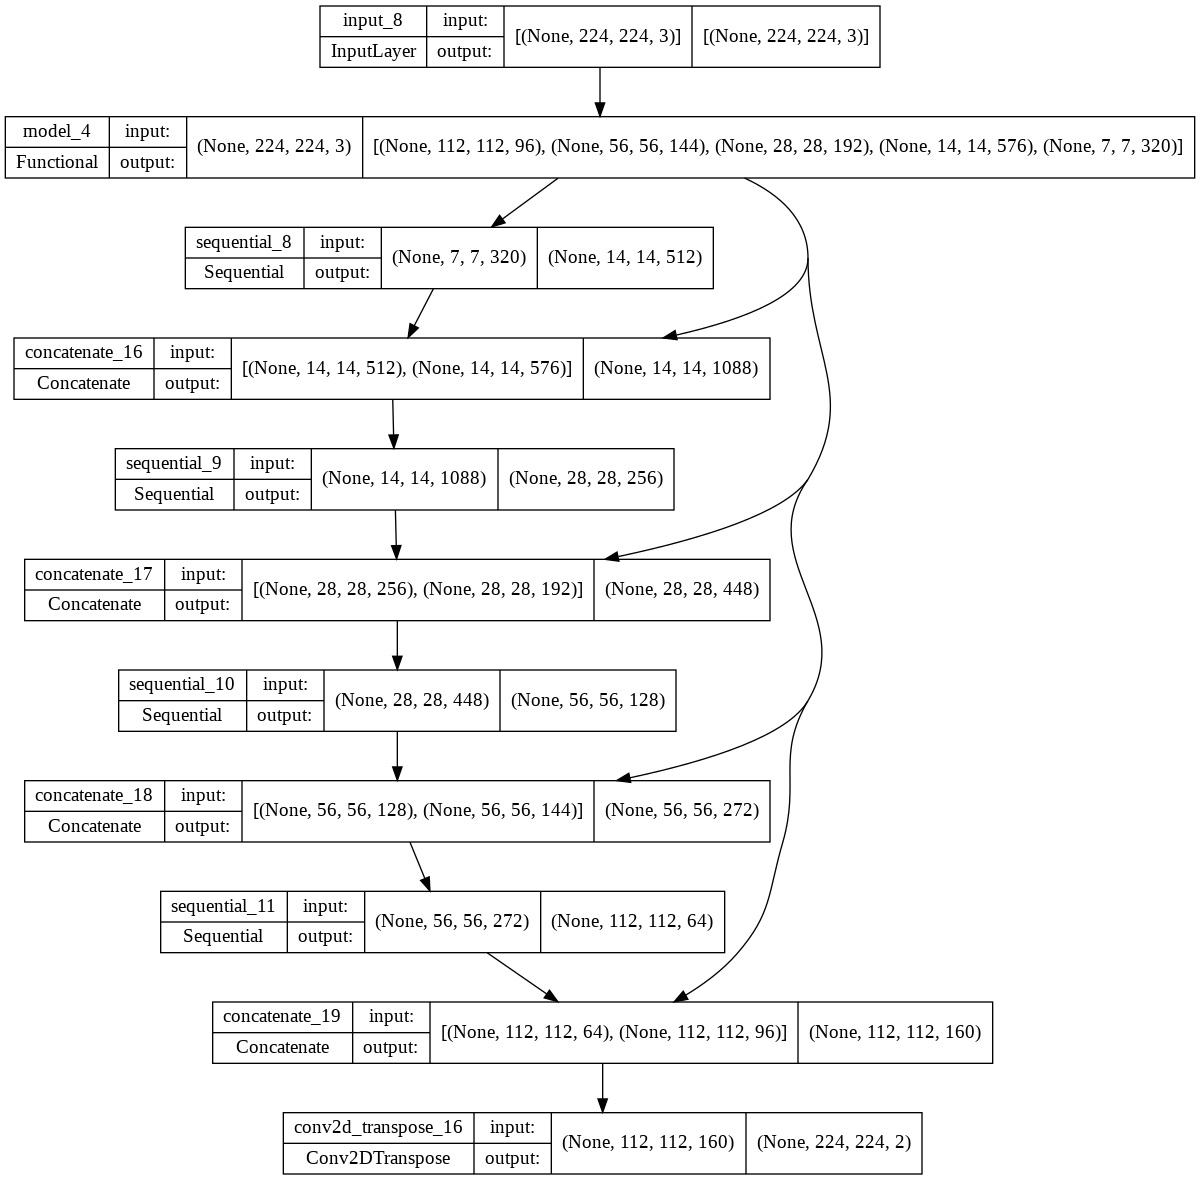

In [120]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)



Epoch 1/50
15/15 [==============================] - 6s 232ms/step - loss: 0.4394 - accuracy: 0.8064 - val_loss: 0.1518 - val_accuracy: 0.9601
Epoch 2/50
15/15 [==============================] - 3s 170ms/step - loss: 0.1594 - accuracy: 0.9563 - val_loss: 0.1029 - val_accuracy: 0.9714
Epoch 3/50
15/15 [==============================] - 2s 167ms/step - loss: 0.1113 - accuracy: 0.9672 - val_loss: 0.0795 - val_accuracy: 0.9743
Epoch 4/50
15/15 [==============================] - 3s 168ms/step - loss: 0.0863 - accuracy: 0.9722 - val_loss: 0.0755 - val_accuracy: 0.9751
Epoch 5/50
15/15 [==============================] - 3s 171ms/step - loss: 0.0739 - accuracy: 0.9749 - val_loss: 0.0715 - val_accuracy: 0.9751
Epoch 6/50
15/15 [==============================] - 3s 172ms/step - loss: 0.0829 - accuracy: 0.9698 - val_loss: 0.0760 - val_accuracy: 0.9730
Epoch 7/50
15/15 [==============================] - 3s 169ms/step - loss: 0.0710 - accuracy: 0.9742 - val_loss: 0.0694 - val_accuracy: 0.9750
Epoch 

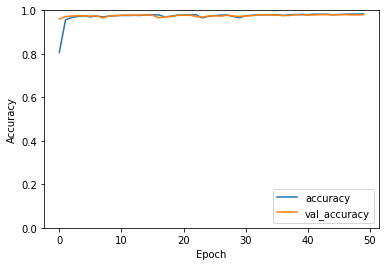

In [121]:
history = model.fit(x_train, y_train, epochs=50,validation_data=(x_valid, y_valid))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_valid,  y_valid, verbose=2)


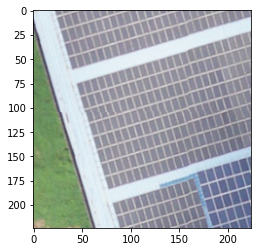

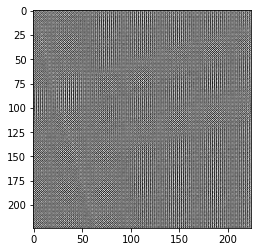

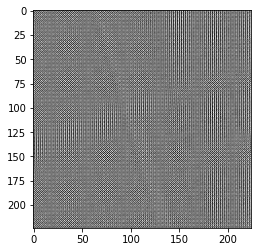

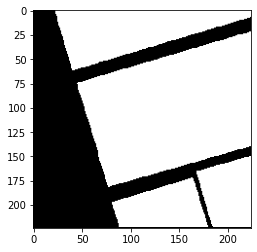

In [81]:
i=22
ivalid=np.resize(x_valid[i],(1,224,224,3))
plt.imshow(x_valid[i])
plt.show()
pred=np.resize(model.predict(ivalid),(2,224,224))
plt.imshow(pred[0],cmap='gray')
plt.show()
plt.imshow(pred[1],cmap='gray')
plt.show()
plt.imshow(y_valid[i],cmap='gray')

In [89]:
def mv(matrix):
  dim=np.size(matrix)
  vector=np.resize(matrix,(dim))
  return vector


import numpy as np

def softmax(x):

    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [104]:
print('El f1 score respecto al conjunto de validacion es el siguiente:',f1_score(np.reshape(y_valid,97*224*224),mv(np.reshape(np.round(softmax(model.predict(x_valid))),(2,97,224,224))[0]),average='binary'))


El f1 score respecto al conjunto de validacion es el siguiente: 0.0


Matriz de confusion para el conujunto de validacion


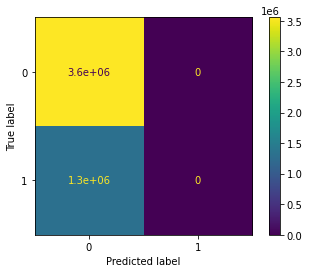

In [107]:
print('Matriz de confusion para el conujunto de validacion')
cm=confusion_matrix(np.reshape(y_valid,97*224*224),mv(np.reshape(np.round(softmax(model.predict(x_valid))),(2,97,224,224))[1]))
cm_display = ConfusionMatrixDisplay(cm).plot()